## Header
Authors: Paul Billing-Ross  
Notebook kernel: Python 3 (ipykernel)  
Recommended Google Cloud machine type: n1-standard-1  
Predicted runtime: < 1 minute  
Predicted cost: NA  
Last updated: June 10, 2022

# Issue #18: Some GVCFs generated by MergeVCFs are missing indexes  

GitHub issue: https://github.com/StanfordBioinformatics/mvp-wgs-snp-indel-release/issues/18

### Context:
Joe identified that some GVCFs generated by the "MergeVCFs" step our GATK SNP-Indel variant calling pipeline were uploaded to cloud storage without indexes. A spot check of the log file from one MergeVCF operation indicated it errored out due to lack of disk space and the index was not generated.

### Goals:
- Understand how common this issues is.
- Compare the size distribution of GVCFS with/without indexes. 
  - Could size difference account for why some VMs ran out of disk during MergeVCFs step?
- Generate a new database query that only retrives GVCFs with indexes.

### Conclusion:
At least one root cause of GVCFs missing indexes is that the MergeVCFs step is running out of disk due to the very large size of some GVCFs.

In [3]:
# Used for calculating runtime
import time
start_marker = time.time()

## Load packages

In [2]:
import os
import yaml

# Data wrangling
import pandas 

# Interface with Neo4j database
from neo4j import GraphDatabase

# Plotting and visualization
import seaborn
import matplotlib.pyplot as plt

## Connect to Trellis Neo4j database & metadata store

In [3]:
## Get database credentials from local YAML
with open(os.path.expanduser("~/credentials/mvp-prod/neo4j.yaml")) as file_handle:
    db_config = yaml.load(file_handle, Loader=yaml.SafeLoader)

In [4]:
## Initialize instance of database driver
db_driver = GraphDatabase.driver(
                f"{db_config['scheme']}://{db_config['ip_address']}:7687",
                auth=(db_config['user'], db_config['key']))

## Calculate number of samples with GVCFs that are missing indexes

In [100]:
## Get number of samples that have GVCFs
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "RETURN COUNT(DISTINCT p) " +
         "AS samples_with_GVCFs")
samples_with_gvcfs = 0 # define it here so it persists after session closes
with db_driver.session() as session:
    samples_with_gvcfs = session.run(query).single().value()
    print(samples_with_gvcfs)

127275


In [9]:
## Get number of samples that have GVCFs with indexes
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN COUNT(DISTINCT p) " +
         "AS samples_with_indexed_gvcf")
samples_with_gvcfs_and_tbis = 0
with db_driver.session() as session:
    samples_with_gvcfs_and_tbis = session.run(query).single().value()
    print(samples_with_gvcfs_and_tbis)

126998


In [112]:
## Samples that have a GVCF but not an index
samples_wo_indexed_gvcfs = samples_with_gvcfs - samples_with_gvcfs_and_tbis
perc_samples_wo_indexed_gvcfs = samples_wo_indexed_gvcfs / samples_with_gvcfs
print(samples_wo_indexed_gvcfs, "samples, %.2f percent of samples with GVCFs" % (perc_samples_wo_indexed_gvcfs * 100))

277 samples, 0.22 percent of samples with GVCFs


In [60]:
## Get count of samples with at least one GVCFs that doesn't have an index
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WHERE NOT (v)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN COUNT(DISTINCT p)")
gvcfs_without_tbis = 0
with db_driver.session() as session:
    gvcfs_without_tbis = session.run(query).single().value()
print(gvcfs_without_tbis)

280


Note: The number of GVCFs without indexs is slightly different from the number of samples. Difference could be due to some samples having duplicate GVCFs, one with and one without an index. In this case, they would be counted in both queries.

## Calculate frequency of GVCF replications

In [45]:
# Calculate frequency of GVCF replication
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WITH p, COLLECT(v) AS gvcfs " +
         "RETURN 'all', size(gvcfs), COUNT(p)")
gvcf_per_sample_counts = []
with db_driver.session() as session:
    gvcf_per_sample_counts = session.run(query).values()
print(gvcf_per_sample_counts)

[['all', 1, 126866], ['all', 2, 376], ['all', 5, 4], ['all', 4, 15], ['all', 12, 1], ['all', 11, 2], ['all', 8, 5], ['all', 10, 1], ['all', 9, 1], ['all', 6, 4]]


In [46]:
# Convert values to to dataframe
gvcf_dup_df = pandas.DataFrame(gvcf_per_sample_counts, columns = ["Index", "Count of GVCFs", "Count of samples"])
gvcf_dup_df.head()

,Index,Count of GVCFs,Count of samples
0,all,1,126866
1,all,2,376
2,all,5,4
3,all,4,15
4,all,12,1


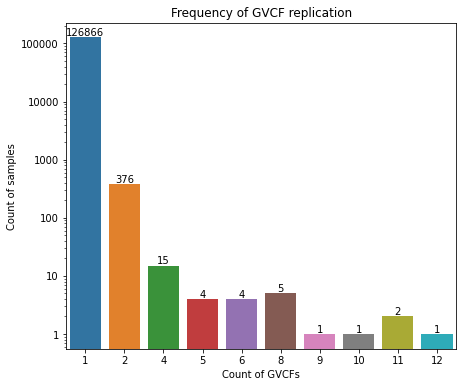

In [116]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
ax.set_title("Figure 1. Frequency of GVCF replication")
plot =seaborn.barplot(data=gvcf_dup_df, x = "Count of GVCFs per sample", y = "Count of samples")

# Add value labels to bars. Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
plot.bar_label(plot.containers[0])

# Change tick values on log axis. Source: https://stackoverflow.com/questions/54151721/how-to-set-ticks-after-log-scale-in-seaborn-facetgrid
ticks = [1,10,100,1000,10000,100000]
labels = [i for i in ticks]
formatted_plot = plot.set(yticks = ticks, yticklabels = labels)

### Calculate frequency of GVCF replications for samples with unindexed GVCFs

In [118]:
# Calculate frequency of GVCF replication for samples with unindexed GVCFs
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WHERE NOT (v)-[:HAS_INDEX]->(:Tbi)"
         "WITH p, COLLECT(v) AS gvcfs " +
         "RETURN 'no index', size(gvcfs), COUNT(p)")
no_tbi_gvcf_per_sample_counts = []
with db_driver.session() as session:
    no_tbi_gvcf_per_sample_counts = session.run(query).values()
print(no_tbi_gvcf_per_sample_counts)

[['no index', 1, 247], ['no index', 5, 4], ['no index', 4, 15], ['no index', 12, 1], ['no index', 11, 2], ['no index', 8, 5], ['no index', 10, 1], ['no index', 9, 1], ['no index', 6, 4]]


In [52]:
# Convert values to to dataframe
joined_gvcfs_freqs = gvcf_per_sample_counts + no_tbi_gvcf_per_sample_counts

no_tbi_gvcf_dup_df = pandas.DataFrame(joined_gvcfs_freqs, columns = ["Index","Count of GVCFs", "Count of samples"])
no_tbi_gvcf_dup_df.head()

,Index,Count of GVCFs,Count of samples
0,all,1,126866
1,all,2,376
2,all,5,4
3,all,4,15
4,all,12,1


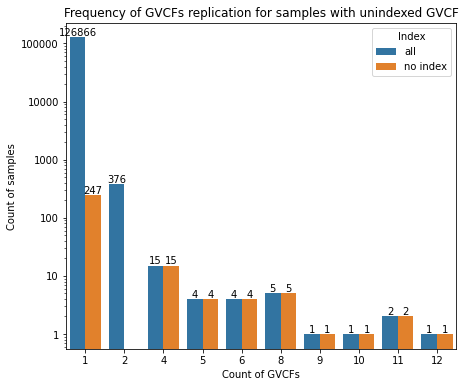

In [113]:
# Initialize the figure with a logarithmic x axis
figure, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
ax.set_title("Figure 2. Frequency of GVCFs replication by index status")
plot = seaborn.barplot(data = no_tbi_gvcf_dup_df, x="Count of GVCFs", y="Count of samples", hue="Index")

# Add value labels to bars. Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
for container in ax.containers: ax.bar_label(container)

# Change tick values on log axis. Source: https://stackoverflow.com/questions/54151721/how-to-set-ticks-after-log-scale-in-seaborn-facetgrid
ticks = [1,10,100,1000,10000,100000]
labels = [i for i in ticks]
replication_frequency_unindexed_gvcfs = plot.set(yticks = ticks, yticklabels = labels)

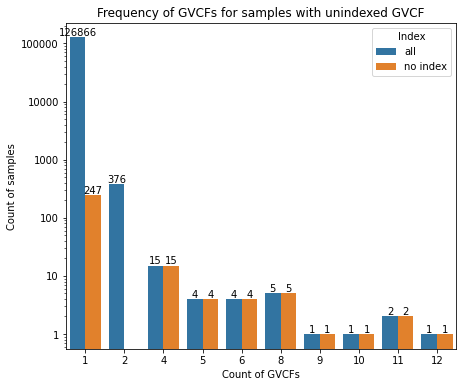

In [92]:
figure

## Compare size of indexed GVCFs to unindexed ones
Preliminary analysis of a log file from a GVCF without an index shows that the VM running "MergeVCFs" ran out of disk space. Because of this, I'm curious if this is an issue that is directly related to the size of the GVCF.  

Issue documentation: https://github.com/StanfordBioinformatics/mvp-wgs-snp-indel-release/issues/18.

### Calculate quartiles for GVCFs without indexes

In [9]:
query = (
         "MATCH (n:PersonalisSequencing)<-[:WAS_USED_BY]-(:Sample)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WHERE NOT (v)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN COUNT(v), " +
         "min(v.size)/1000000000 as min_size_gb, " +
         "percentileCont(v.size,0.25)/1000000000 as q1_gb, " +
         "percentileCont(v.size,0.5)/1000000000 as q2_gb, " +
         "percentileCont(v.size,0.75)/1000000000 as q3_gb, " +
         "max(v.size)/1000000000 as max_size_gb")
no_index_quartiles_gb = []
with db_driver.session() as session:
    no_index_quartiles_gb = session.run(query).single().values()
print(no_index_quartiles_gb)

[444, 2, 6.90520970175, 7.7667422605, 10.990342144, 12]


Neo4j does not have a built-in median function so in this case the middle value corresponds to the second quartile (50% of values below).

### Calculate quartiles for GVCFs with indexes

In [10]:
query = (
         "MATCH (n:PersonalisSequencing)<-[:WAS_USED_BY]-(:Sample)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN COUNT(v), " +
         "min(v.size)/1000000000 as min_size_gb, " +
         "percentileCont(v.size,0.25)/1000000000 as q1_gb, " +
         "percentileCont(v.size,0.5)/1000000000 as q2_gb, " +
         "percentileCont(v.size,0.75)/1000000000 as q3_gb, " +
         "max(v.size)/1000000000 as max_size_gb")
indexed_quartiles_gb = []
with db_driver.session() as session:
    indexed_quartiles_gb = session.run(query).single().values()
print(indexed_quartiles_gb)

[127443, 1, 6.1595945195, 6, 6.9728248415, 12]


## Create boxplots comparing indexed and non-indexed GVCFs
For generating boxplots I'm going to run a new set of queries to pull all the size data points. Initially I was going to pull the quantile metrics and generate boxplots from those, but after doing a little digging it seems like generating figures from summary statistics is more trouble than it's worth (and generates a less specific data representation). So I'm going to export/transmit more data for the sake of generating nice figures.

### Get size values for all unindexed GVCFs

In [8]:
query = (
         "MATCH (:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WHERE NOT (v)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN 'unindexed', v.size/1000000000.0 AS gvcf_size_gb")
unindexed_sizes_gb = []
with db_driver.session() as session:
    unindexed_sizes_gb = session.run(query).values()
print(unindexed_sizes_gb[0:5])

[['unindexed', 6.021574834], ['unindexed', 6.391804473], ['unindexed', 7.462491334], ['unindexed', 6.093032756], ['unindexed', 7.643318109]]


### Get size values for all indexed GVCFs

In [9]:
query = (
         "MATCH (:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->" +
         "(v:Merged:Vcf)-[:HAS_INDEX]->(:Tbi) " +
         "RETURN 'indexed', v.size/1000000000.0 AS gvcf_size_gb")
indexed_sizes_gb = []
with db_driver.session() as session:
    indexed_sizes_gb = session.run(query).values()
print(indexed_sizes_gb[0:5])

[['indexed', 6.141964636], ['indexed', 5.937309921], ['indexed', 6.778319855], ['indexed', 6.298066173], ['indexed', 7.070731634]]


In [10]:
# Combine list of lists
print(len(indexed_sizes_gb))
print(len(unindexed_sizes_gb))
joined_lists = indexed_sizes_gb + unindexed_sizes_gb
print(len(joined_lists))

127443
444
127887


In [11]:
data_frame = pandas.DataFrame(joined_lists, columns = ["index_status", "gvcf_size_gb"])
data_frame.head()

,index_status,gvcf_size_gb
0,indexed,6.141965
1,indexed,5.937310
2,indexed,6.778320
3,indexed,6.298066
4,indexed,7.070732


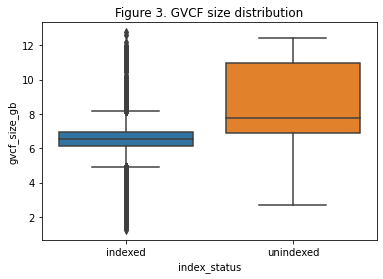

In [15]:
box_plot = seaborn.boxplot(
                x="index_status", 
                y="gvcf_size_gb",
                data = data_frame) \
                    .set_title("Figure 3. GVCF size distribution")

Based on Figure 2 and the MergeVCF log files, I think we may be observing at least two issues causing GVCFs to be generated and/or registered in the database without indexes. When the MergeVCF job fails (e.g. due to out-of-disk error) it will retry the job a fixed amount of times. Samples with multiple replicate GVCFs without indexes could be the result of this issue while single GVCFs without indexes could be from a different issue. So, I'm going to just look at the file sizes of GVCFs with replicates.

In [6]:
query = (
         "MATCH (p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf) " +
         "WHERE NOT (v)-[:HAS_INDEX]->(:Tbi) " +
         "WITH p, COLLECT(v) AS gvcfs " +
         "WHERE size(gvcfs) > 1 " +
         "WITH p, head(gvcfs) AS gvcf " +
         "RETURN 'replicate', gvcf.size/1000000000.0")
replicate_gvcf_sizes_gb = []
with db_driver.session() as session:
    replicate_gvcf_sizes_gb = session.run(query).values()
print(replicate_gvcf_sizes_gb[0:5])

[['replicate', 11.140354048], ['replicate', 10.689601536], ['replicate', 10.92261888], ['replicate', 11.222654976], ['replicate', 10.769256448]]


In [17]:
# Combine lists
joined_lists += replicate_gvcf_sizes_gb
print(len(joined_lists))

127920


In [19]:
data_frame = pandas.DataFrame(joined_lists, columns = ["index_status", "gvcf_size_gb"])
data_frame.head()

,index_status,gvcf_size_gb
0,indexed,6.141965
1,indexed,5.937310
2,indexed,6.778320
3,indexed,6.298066
4,indexed,7.070732


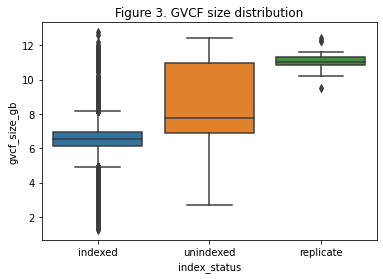

In [20]:
box_plot = seaborn.boxplot(
                x="index_status", 
                y="gvcf_size_gb",
                data = data_frame) \
                    .set_title("Figure 3. GVCF size distribution")

# Conclusion
At least one root cause of GVCFs missing indexes is that the MergeVCFs step is running out of disk due to the very large size of some GVCFs. We can identify these GVCFs by the presence of duplicates.

# Get a single indexed GVCF per sample
In this case, we want samples from individuals who have Covid phenotypes but who have not been included in data release 1.

In [16]:
# Count the number of Covid19 participants that have an indexed GVCF and are not part of data release 1
query = (
         "MATCH (n:Study {name:'Covid19'})-[:HAS_PARTICIPANT]->(:Participant)-[:IS]->(p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf)-[:HAS_INDEX]->(:Tbi) " +
         "WHERE NOT (:Study {name:'WgsDataRelease1'})-[:HAS_PARTICIPANT]->(:Participant)-[:IS]->(p) " +
         "RETURN COUNT(DISTINCT p)")
unique_participants = 0
with db_driver.session() as session:
    unique_participants = session.run(query).value()
print(unique_participants)

[11065]


In [17]:
# Get a single indexed GVCF, for each of those participants
query = (
         "MATCH (n:Study {name:'Covid19'})-[:HAS_PARTICIPANT]->(:Participant)-[:IS]->(p:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf)-[:HAS_INDEX]->(:Tbi) " +
         "WHERE NOT (:Study {name:'WgsDataRelease1'})-[:HAS_PARTICIPANT]->(:Participant)-[:IS]->(p) " +
         "WITH v.sample AS sample, COLLECT(v) AS gvcfs " +
         "WITH head(gvcfs) AS gvcf " +
         "RETURN COUNT(gvcf)")
unique_indexed_gvcfs = 0
with db_driver.session() as session:
    unique_indexed_gvcfs = session.run(query).value()
print(unique_indexed_gvcfs)

[11065]


In [18]:
if unique_participants != unique_indexed_gvcfs:
    raise ValueError("Number of indexed GVCFs does not match number of participants.")

In [19]:
end_marker = time.time()
print("This took %.2f seconds" % (end_marker - start_marker))

This took 22.87 seconds
